In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.ops import array_ops

from tfshow import show_graph
from models.linear_regression import LinearRegression2Blocks

## Derivation for Linear Regression
Suppose $x^{1\times p}, X^{n\times p}, y^{n\times 1}$.
$$
\begin{split}
R_{emp} = \frac{1}{n}(y-X\beta)^{\top} (y-X\beta) \qquad&(1\times 1)\\
\nabla^2_{\beta}R_{emp} = \frac{2}{n}X^{\top}X \qquad&(p\times p)
\end{split}
$$
For some fixed validation or training point $z = (x,y)$
$$
\begin{split}
L(z;\hat{\beta}) = (y-x\hat{\beta})^{\top} (y-x\hat{\beta}) \qquad&(1\times 1)\\
\nabla_{\beta}L(z;\hat{\beta}) = -2x^{\top} (y-x\hat{\beta})\qquad&(p\times 1)\\
p = (\nabla^2_{\beta}R_{emp})^{-1}\nabla_{\beta}L(z_{te};\hat{\beta})\qquad&(p\times 1), \text{ Hessian-vector product}\\
u := \nabla_{\beta}L(z_{tr})=-2x_{tr}^{\top}(y_{tr}-x_{tr}\hat{\beta}) \qquad&(1\times p), \text{ Gradient of loss of 1 training point}\\
\mathcal{I}_{loss}(\color{red}{z_{tr}}, \color{blue}{z_{te}}) = u^{\top}p = 2n\color{red}{(y_{tr}-x_{tr}\hat{\beta})^{\top}x_{tr}}(X^{\top}X)^{-1}\color{blue}{x_{te}^{\top}(y_{te}-x_{te}\hat{\beta})}\qquad&(1\times 1)
\end{split}
$$

In [3]:
df = pd.read_csv('data/lm_10.csv')
n = len(df)
X = df.values[:, 0:10]
y = df.values[:, -1].reshape(n, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)
n, p = X_train.shape

(80, 10)
(20, 10)
(80, 1)
(20, 1)


## Theoretical Calculation

In [4]:
def I_loss_closed_form(X_tr, Y_tr, X_te, Y_te):
    n_tr, p = X_tr.shape
    n_te, _ = X_te.shape
    beta_hat = np.linalg.inv(
        X_tr.T.dot(X_tr)).dot(X_tr.T).dot(Y_tr)
    H_inv = (n_tr/2)*np.linalg.inv((X_tr.T.dot(X_tr)))
    I_loss = np.zeros((n_tr, n_te))
    for i in range(n_tr):
        for j in range(n_te):
            x_tr, y_tr = X_tr[i:i+1,:], Y_tr[i:i+1,:]
            x_te, y_te = X_te[j:j+1,:], Y_te[j:j+1,:]
            grad_tr = -2*x_tr.T.dot(y_tr - x_tr.dot(beta_hat))
            grad_te = -2*x_te.T.dot(y_te - x_te.dot(beta_hat))
            I_loss[i,j] = grad_tr.T.dot(H_inv).dot(grad_te)
    return I_loss

I_loss_cf = I_loss_closed_form(X_train, y_train, X_test, y_test)

## Test the Model

In [5]:
model = LinearRegression2Blocks(
    model_name='LinearRegression2Blocks',
    eta=0.01)
model.fit(X_train, y_train, n_iter=10000)

Step 0: loss = 151.12817383 (0.036 sec)
Step 1000: loss = 1.13385546 (0.002 sec)
Step 2000: loss = 1.13385534 (0.000 sec)
Step 3000: loss = 1.13385534 (0.000 sec)
Step 4000: loss = 1.13385534 (0.000 sec)
Step 5000: loss = 1.13385534 (0.000 sec)
Step 6000: loss = 1.13385534 (0.000 sec)
Step 7000: loss = 1.13385534 (0.000 sec)
Step 8000: loss = 1.13385534 (0.000 sec)
Step 9000: loss = 1.13385534 (0.000 sec)


LinearRegression2Blocks(eta=0.01)

In [6]:
show_graph(tf.get_default_graph())

In [7]:
%%time
I_loss_bf = model.influence_loss(
    X_test, y_test, method='brute-force')

Fetch training loss gradients (0.107 sec)
CPU times: user 283 ms, sys: 14.6 ms, total: 298 ms
Wall time: 348 ms


In [8]:
abs_pct_error = 100*np.abs(
    I_loss_bf - I_loss_cf) / np.abs(I_loss_cf)
print("Absolute percentage error to closed form:")
for row in abs_pct_error:
    print([('%.3f' % x) + '%' for x in row])

Absolute percentage error to closed form:
['0.006%', '0.002%', '0.003%', '0.590%', '0.009%', '0.023%', '0.007%', '0.028%', '0.021%', '0.004%', '0.002%', '0.011%', '0.005%', '0.002%', '0.000%', '0.005%', '0.007%', '0.014%', '0.006%', '0.001%']
['0.000%', '0.009%', '0.003%', '0.584%', '0.002%', '0.016%', '0.000%', '0.035%', '0.027%', '0.003%', '0.009%', '0.004%', '0.001%', '0.005%', '0.006%', '0.001%', '0.001%', '0.007%', '0.001%', '0.005%']
['0.002%', '0.006%', '0.000%', '0.587%', '0.005%', '0.026%', '0.003%', '0.032%', '0.024%', '0.000%', '0.006%', '0.007%', '0.001%', '0.002%', '0.004%', '0.002%', '0.004%', '0.010%', '0.002%', '0.002%']
['0.023%', '0.031%', '0.026%', '0.561%', '0.021%', '0.007%', '0.023%', '0.057%', '0.050%', '0.025%', '0.031%', '0.019%', '0.024%', '0.028%', '0.029%', '0.024%', '0.022%', '0.016%', '0.024%', '0.028%']
['0.007%', '0.002%', '0.004%', '0.591%', '0.009%', '0.023%', '0.008%', '0.028%', '0.020%', '0.004%', '0.002%', '0.011%', '0.006%', '0.002%', '0.001%', '0.

## Test Against LOO

In [9]:
%%time
I_loss_loo = model.leave_one_out_refit(
    X_test, y_test, n_iter=1000)

LOO Fold 0: loss = 1.14274800 (0.557 sec)
LOO Fold 8: loss = 1.14815354 (0.597 sec)
LOO Fold 16: loss = 1.14723504 (0.717 sec)
LOO Fold 24: loss = 1.08481216 (0.659 sec)
LOO Fold 32: loss = 1.14790761 (0.535 sec)
LOO Fold 40: loss = 1.14130855 (0.515 sec)
LOO Fold 48: loss = 1.14709246 (0.562 sec)
LOO Fold 56: loss = 1.13606179 (0.563 sec)
LOO Fold 64: loss = 1.14732301 (0.525 sec)
LOO Fold 72: loss = 1.12661207 (0.505 sec)
CPU times: user 57.2 s, sys: 7.69 s, total: 1min 4s
Wall time: 44.4 s


In [10]:
def LOO_closed_form(X_tr, Y_tr, X_te, Y_te):
    l2_loss = lambda x,y,b: (y-x.dot(b))**2
    n_tr, p = X_tr.shape
    n_te, _ = X_te.shape
    beta_hat = np.linalg.inv(
        X_tr.T.dot(X_tr)).dot(X_tr.T).dot(Y_tr)
    L_full = l2_loss(X_te, Y_te, beta_hat)
    loss_diff = np.zeros((n_tr, n_te))
    for i in range(n_tr):
        rest_indices = [idx for idx in range(n_tr) if idx!=i]
        X_loo, Y_loo = X_tr[rest_indices, :], Y_tr[rest_indices, :]
        beta_loo = np.linalg.inv(
            X_loo.T.dot(X_loo)).dot(X_loo.T).dot(Y_loo)
        L_loo = l2_loss(X_te, Y_te, beta_loo)
        loss_diff[i, :] = (L_full - L_loo).T
    return loss_diff

# closed form loo loss difference
loo_loss_cf = LOO_closed_form(X_train, y_train, X_test, y_test)

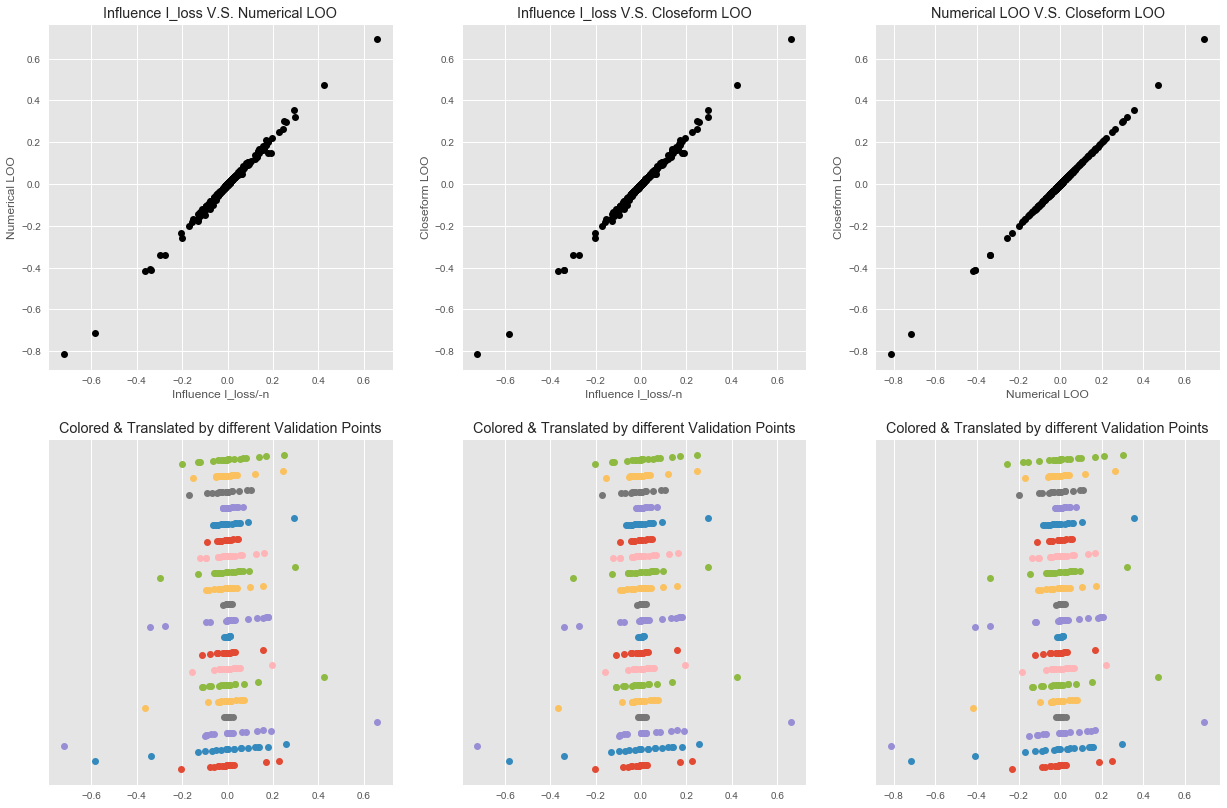

In [11]:
fig, axes = plt.subplots(2, 3 ,figsize=(21,14))
n_tr, _ = X_train.shape
n_te, _ = X_test.shape

for j in range(n_te):
    axes[0,0].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:], 
                 'o', color='black')
    axes[0,1].plot(I_loss_bf[j,:]/(-n_tr), loo_loss_cf[j,:], 
                 'o', color='black')
    axes[0,2].plot(I_loss_loo[j,:], loo_loss_cf[j,:], 
                 'o', color='black')
    
    axes[1,0].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:]+j, 'o')
    axes[1,1].plot(I_loss_bf[j,:]/(-n_tr), loo_loss_cf[j,:]+j, 'o')
    axes[1,2].plot(I_loss_loo[j,:], loo_loss_cf[j,:]+j, 'o')

axes[0,0].update({
    'title':'Influence I_loss V.S. Numerical LOO',
    'xlabel': 'Influence I_loss/-n',
    'ylabel': 'Numerical LOO'})
axes[0,1].update({
    'title':'Influence I_loss V.S. Closeform LOO',
    'xlabel': 'Influence I_loss/-n',
    'ylabel': 'Closeform LOO'})
axes[0,2].update({
    'title':'Numerical LOO V.S. Closeform LOO',
    'xlabel': 'Numerical LOO',
    'ylabel': 'Closeform LOO'})
axes[1,0].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
axes[1,1].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
_ = axes[1,2].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})

## Conjugate GD Approximation

In [12]:
%%time
I_loss_cg = model.influence_loss(
    X_test, y_test, method='cg')

Fetch training loss gradients (0.042 sec)
CG Objective: -8.428468
CG Objective: -8.572284
CG Objective: -8.578905
CG Objective: -8.580218
CG Objective: -8.580231
CG Objective: -8.580231
         Current function value: -8.580231
         Iterations: 6
         Function evaluations: 75
         Gradient evaluations: 80
         Hessian evaluations: 17
CG Objective: -3.685835
CG Objective: -3.7458355
CG Objective: -3.7509198
CG Objective: -3.7518895
CG Objective: -3.7519064
         Current function value: -3.751906
         Iterations: 5
         Function evaluations: 82
         Gradient evaluations: 76
         Hessian evaluations: 12
CG Objective: -33.126286
CG Objective: -34.653263
CG Objective: -34.750957
CG Objective: -34.758533
CG Objective: -34.75917
CG Objective: -34.75926
CG Objective: -34.75927
         Current function value: -34.759270
         Iterations: 7
         Function evaluations: 77
         Gradient evaluations: 73
         Hessian evaluations: 14
CG Objective: -0

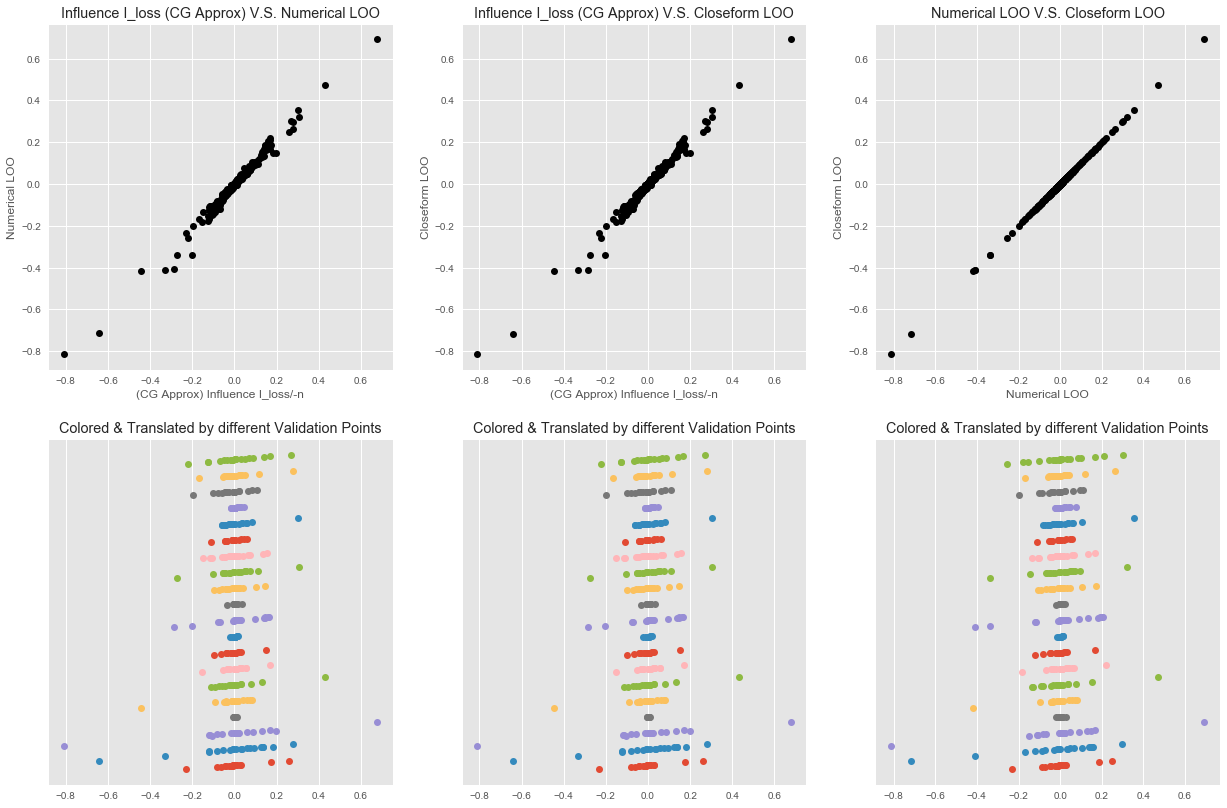

In [13]:
fig, axes = plt.subplots(2, 3 ,figsize=(21,14))
n_tr, _ = X_train.shape
n_te, _ = X_test.shape

for j in range(n_te):
    axes[0,0].plot(I_loss_cg[j,:]/(-n_tr), I_loss_loo[j,:], 
                 'o', color='black')
    axes[0,1].plot(I_loss_cg[j,:]/(-n_tr), loo_loss_cf[j,:], 
                 'o', color='black')
    axes[0,2].plot(I_loss_cg[j,:]/(-n_tr), I_loss_bf[j,:]/(-n_tr), 
                 'o', color='black')
    
    axes[1,0].plot(I_loss_cg[j,:]/(-n_tr), I_loss_loo[j,:]+j, 'o')
    axes[1,1].plot(I_loss_cg[j,:]/(-n_tr), loo_loss_cf[j,:]+j, 'o')
    axes[1,2].plot(I_loss_cg[j,:]/(-n_tr), I_loss_bf[j,:]/(-n_tr)+j, 'o')

axes[0,0].update({
    'title':'Influence I_loss (CG Approx) V.S. Numerical LOO',
    'xlabel': '(CG Approx) Influence I_loss/-n',
    'ylabel': 'Numerical LOO'})
axes[0,1].update({
    'title':'Influence I_loss (CG Approx) V.S. Closeform LOO',
    'xlabel': '(CG Approx) Influence I_loss/-n',
    'ylabel': 'Closeform LOO'})
axes[0,2].update({
    'title':'Influence I_loss (CG Approx) V.S. Closeform LOO',
    'xlabel': 'Numerical LOO',
    'ylabel': 'Closeform LOO'})
axes[1,0].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
axes[1,1].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
_ = axes[1,2].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})